# 03 — Resultados E0: consolidación, deltas y plots

Este notebook lee los outputs de **E0** y genera:
- Tabla consolidada (global) por modelo y feature set
- Deltas vs baseline (FS0)
- Figuras (barras) para incluir en la memoria

Requiere haber ejecutado **08_run_E0_ablation_training.ipynb** (para crear `outputs/E0_ablation/summary_metrics.csv`).

In [ ]:
from __future__ import annotations

import json
import sys
from pathlib import Path

import pandas as pd

# Ensure PROJECT_ROOT is on sys.path so `import src.*` works reliably
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR
if (PROJECT_ROOT / 'src').exists() is False and (PROJECT_ROOT.parent / 'src').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
sys.path.insert(0, str(PROJECT_ROOT))

from src.common import TEST_WEEKS, evaluate_predictions, get_E2_test_mask, load_data, make_features
from src.e0_ablation_utils import get_project_paths

paths = get_project_paths(project_root=PROJECT_ROOT, output_dir='outputs/E0_ablation')
OUTPUT_DIR = paths.output_dir
DATA_PATH = paths.data_path

summary_path = OUTPUT_DIR / 'summary_metrics.csv'
feature_sets_path = OUTPUT_DIR / 'feature_sets.json'

print('OUTPUT_DIR:', OUTPUT_DIR)
print('DATA_PATH:', DATA_PATH)
print('feature_sets_path:', feature_sets_path, 'exists=', feature_sets_path.exists())
print('summary_path:', summary_path)

OUTPUT_DIR: C:\Users\usuario\Documents\Master AI\TFM\MEMORIA 2.0\outputs\E0_ablation
DATA_PATH: C:\Users\usuario\Documents\Master AI\TFM\MEMORIA 2.0\data\Walmart_Sales.csv
feature_sets_path: C:\Users\usuario\Documents\Master AI\TFM\MEMORIA 2.0\outputs\E0_ablation\feature_sets.json exists= True
summary_path: C:\Users\usuario\Documents\Master AI\TFM\MEMORIA 2.0\outputs\E0_ablation\summary_metrics.csv


In [ ]:
if not feature_sets_path.exists():
    raise FileNotFoundError(f'Missing {feature_sets_path}. Run notebook 01 first.')

feature_sets = json.loads(feature_sets_path.read_text(encoding='utf-8'))
df = load_data(DATA_PATH)
df_feat_full, _ = make_features(df, add_calendar=True)

fs2_cols = feature_sets['FS2']['feature_cols']
e2_mask, e2_split = get_E2_test_mask(df_feat_full, test_weeks=TEST_WEEKS)
mask_no_nan_fs2 = df_feat_full[fs2_cols + ['Weekly_Sales']].notna().all(axis=1)
eval_mask_common = e2_mask & mask_no_nan_fs2
mask_df = df_feat_full.loc[eval_mask_common, ['Store','Date']]

print('E2 test window:', e2_split['test_start'], '→', e2_split['test_end'])
print('Stores in mask:', mask_df['Store'].nunique())
print('Points in eval_mask_common:', len(mask_df))

E2 test window: 2012-02-03 → 2012-10-26
Stores in mask: 45
Points in eval_mask_common: 1755


In [ ]:
import numpy as np

def compute_metrics(df, group_col='Store', y_true_col='y_true', y_pred_col='y_pred'):
    y_true = df[y_true_col].astype(float).to_numpy()
    y_pred = df[y_pred_col].astype(float).to_numpy()
    err = y_true - y_pred

    mae_micro = float(np.mean(np.abs(err)))
    rmse_micro = float(np.sqrt(np.mean(err ** 2)))
    denom_smape = np.abs(y_true) + np.abs(y_pred)
    smape_micro = float(np.mean(np.where(denom_smape == 0, 0.0, 200.0 * np.abs(err) / denom_smape)))

    denom_wape = float(np.sum(np.abs(y_true)))
    wape_micro = float(np.sum(np.abs(err)) / denom_wape) if denom_wape != 0 else float('nan')

    mae_macro = float('nan')
    wape_macro = float('nan')
    if group_col in df.columns:
        g = df.groupby(group_col)
        mae_store = g.apply(lambda x: np.mean(np.abs(x[y_true_col] - x[y_pred_col])))
        wape_store = g.apply(
            lambda x: (
                np.sum(np.abs(x[y_true_col] - x[y_pred_col]))
                / np.sum(np.abs(x[y_true_col]))
                if np.sum(np.abs(x[y_true_col])) != 0
                else np.nan
            )
        )
        mae_macro = float(np.nanmean(mae_store))
        wape_macro = float(np.nanmean(wape_store))

    return {
        'mae_micro': mae_micro,
        'mae_macro': mae_macro,
        'rmse_micro': rmse_micro,
        'smape_micro': smape_micro,
        'wape_micro': wape_micro,
        'wape_macro': wape_macro,
    }

rows = []
for pred_path in OUTPUT_DIR.glob('*__FS*/predictions/test_predictions.csv'):
    run_dir = pred_path.parent.parent
    parts = run_dir.name.split('__', 1)
    if len(parts) != 2:
        continue
    model_label, fs_name = parts

    pred = pd.read_csv(pred_path)
    pred['Date'] = pd.to_datetime(pred['Date'])
    pred = pred.merge(mask_df, on=['Store','Date'], how='inner')
    if pred.empty:
        continue

    m = compute_metrics(pred, group_col='Store')

    rows.append({
        'model': model_label,
        'feature_set': fs_name,
        'mae_global_micro': m['mae_micro'],
        'mae_store_macro': m['mae_macro'],
        'RMSE': m['rmse_micro'],
        'sMAPE': m['smape_micro'],
        'wape_global_micro': m['wape_micro'],
        'wape_store_macro': m['wape_macro'],
        'n_points': len(pred),
    })

if not rows:
    raise RuntimeError('No predictions found in outputs/E0_ablation/*__FS*/predictions/test_predictions.csv')

summary = pd.DataFrame(rows).sort_values(['model','feature_set']).reset_index(drop=True)
display(summary)

if not summary.empty:
    ex = summary.iloc[0]
    print(f"Example {ex['model']} {ex['feature_set']} | MAE={ex['mae_global_micro']:.3f} | WAPE={ex['wape_global_micro']:.4f}")
    print('WAPE_micro range:', summary['wape_global_micro'].min(), summary['wape_global_micro'].max())

summary.to_csv(summary_path, index=False)
print('Saved:', summary_path)

,model,feature_set,mae_global_micro,mae_store_macro,RMSE,sMAPE,n_points
0,lstm_exog,FS0,498803.916637,498803.916637,615527.684820,60.957842,1755
1,lstm_exog,FS1,715894.886941,715894.886941,819447.415702,109.518243,1755
2,lstm_exog,FS2,484668.400916,484668.400916,596656.506938,54.880722,1755
3,transformer_exog,FS0,330957.363771,330957.363771,392481.497741,36.759372,1755
4,transformer_exog,FS1,490950.961268,490950.961268,577818.389430,57.917571,1755
5,transformer_exog,FS2,433880.420127,433880.420127,501104.942122,51.617952,1755


Saved: C:\Users\usuario\Documents\Master AI\TFM\MEMORIA 2.0\outputs\E0_ablation\summary_metrics.csv


## Tabla pivot (métricas globales)
Pivot por modelo y feature set para inspección rápida.

In [ ]:
metrics = ['mae_global_micro','RMSE','sMAPE','wape_global_micro','mae_store_macro','wape_store_macro']
pivot = summary.pivot_table(index='model', columns='feature_set', values=metrics)
display(pivot)

RMSE                                \
feature_set                 FS0            FS1            FS2   
model                                                           
lstm_exog         615527.684820  819447.415702  596656.506938   
transformer_exog  392481.497741  577818.389430  501104.942122   

                 mae_global_micro                                \
feature_set                   FS0            FS1            FS2   
model                                                             
lstm_exog           498803.916637  715894.886941  484668.400916   
transformer_exog    330957.363771  490950.961268  433880.420127   

                 mae_store_macro                                    sMAPE  \
feature_set                  FS0            FS1            FS2        FS0   
model                                                                       
lstm_exog          498803.916637  715894.886941  484668.400916  60.957842   
transformer_exog   330957.363771  490950.961268  433880.420127  36.759372   

                                         
feature_set              FS1        FS2  
model                                    
lstm_exog         109.518243  54.880722  
transformer_exog   57.917571  51.617952

## Deltas vs FS0
Calculamos $\Delta$ por métrica y modelo, donde $\Delta = metric(FSx) - metric(FS0)$.
- Valores negativos en MAE/RMSE/sMAPE implican mejora.

In [ ]:
base = summary[summary['feature_set'] == 'FS0'][['model'] + metrics].set_index('model')

deltas = summary.copy()
for m in metrics:
    deltas[m] = deltas.apply(lambda r: r[m] - base.loc[r['model'], m], axis=1)

deltas = deltas.sort_values(['model','feature_set']).reset_index(drop=True)
display(deltas)

delta_path = OUTPUT_DIR / 'summary_deltas_vs_FS0.csv'
deltas.to_csv(delta_path, index=False)
print('Saved:', delta_path)

,model,feature_set,mae_global_micro,mae_store_macro,RMSE,sMAPE,n_points
0,lstm_exog,FS0,0.000000,0.000000,0.000000,0.000000,1755
1,lstm_exog,FS1,217090.970304,217090.970304,203919.730882,48.560400,1755
2,lstm_exog,FS2,-14135.515720,-14135.515720,-18871.177882,-6.077120,1755
3,transformer_exog,FS0,0.000000,0.000000,0.000000,0.000000,1755
4,transformer_exog,FS1,159993.597497,159993.597497,185336.891689,21.158199,1755
5,transformer_exog,FS2,102923.056356,102923.056356,108623.444381,14.858580,1755


Saved: C:\Users\usuario\Documents\Master AI\TFM\MEMORIA 2.0\outputs\E0_ablation\summary_deltas_vs_FS0.csv


## Plots
Generamos gráficos de barras para cada métrica y los guardamos en `outputs/E0_ablation/figures/`.

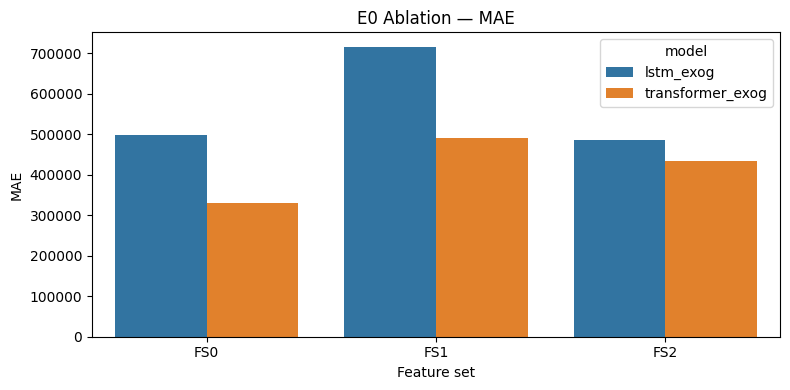

Saved: C:\Users\usuario\Documents\Master AI\TFM\MEMORIA 2.0\outputs\E0_ablation\figures\e0_ablation_MAE.png


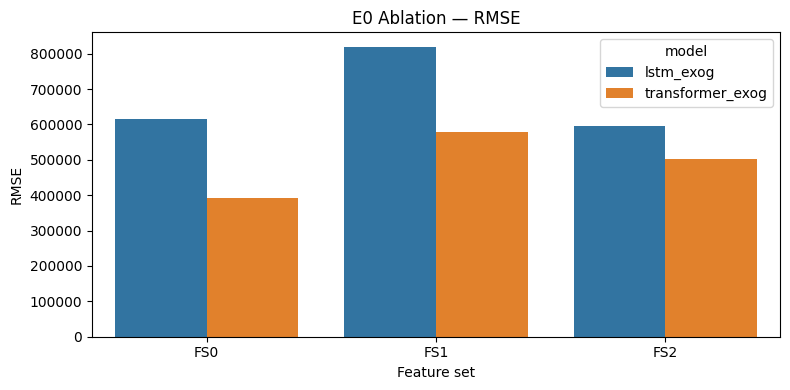

Saved: C:\Users\usuario\Documents\Master AI\TFM\MEMORIA 2.0\outputs\E0_ablation\figures\e0_ablation_RMSE.png


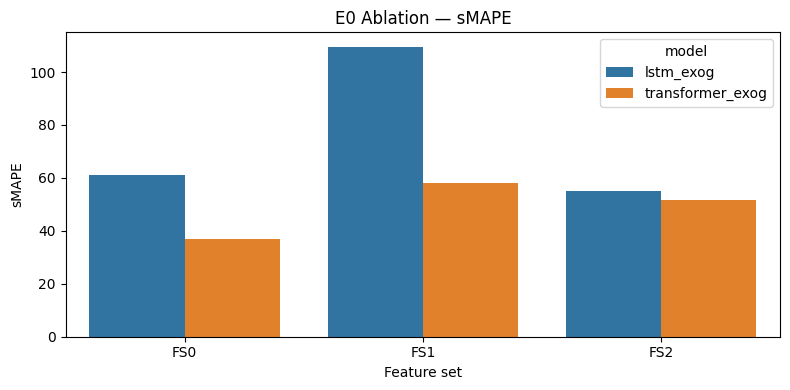

Saved: C:\Users\usuario\Documents\Master AI\TFM\MEMORIA 2.0\outputs\E0_ablation\figures\e0_ablation_sMAPE.png


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig_dir = OUTPUT_DIR / 'figures'
fig_dir.mkdir(parents=True, exist_ok=True)

order_fs = ['FS0','FS1','FS2']
metrics_plot = ['mae_global_micro','RMSE','sMAPE','wape_global_micro']
label_map = {'mae_global_micro': 'MAE', 'wape_global_micro': 'WAPE'}

for m in metrics_plot:
    label = label_map.get(m, m)
    plt.figure(figsize=(8, 4))
    sns.barplot(data=summary, x='feature_set', y=m, hue='model', order=order_fs)
    plt.title(f'E0 Ablation — {label}')
    plt.xlabel('Feature set')
    plt.ylabel(label)
    plt.tight_layout()
    out = fig_dir / f'e0_ablation_{label}.png'
    plt.savefig(out, dpi=160)
    plt.show()
    plt.close()
    print('Saved:', out)

## Export rápido para LaTeX (opcional)
Genera una tabla `.tex` con `pandas.to_latex()` basada en `summary_metrics.csv`.

Si prefieres una tabla con formato específico de la plantilla, usa `[COMPLETAR: ...]` y la adaptamos.

In [ ]:
tex_dir = OUTPUT_DIR / 'tables'
tex_dir.mkdir(parents=True, exist_ok=True)

tbl = (
    summary
    .sort_values(['model','feature_set'])
    [[
        'model','feature_set',
        'mae_global_micro','RMSE','sMAPE','wape_global_micro',
        'mae_store_macro','wape_store_macro',
    ]]
    .rename(columns={
        'mae_global_micro':'MAE_global_micro',
        'mae_store_macro':'MAE_store_macro',
        'wape_global_micro':'WAPE_global_micro',
        'wape_store_macro':'WAPE_store_macro',
    })
)
tex_path = tex_dir / 'e0_ablation_summary.tex'
tex_path.write_text(tbl.to_latex(index=False, float_format='%.4f'), encoding='utf-8')
print('Saved:', tex_path)

Saved: C:\Users\usuario\Documents\Master AI\TFM\MEMORIA 2.0\outputs\E0_ablation\tables\e0_ablation_summary.tex
